## Evaluate WoFSCast Performance 

In [1]:
# From WoFSCast
import sys, os 
sys.path.insert(0, os.path.dirname(os.path.dirname(os.getcwd())))

from wofscast.model import WoFSCastModel
from wofscast.data_generator import open_zarr
from plot_params import target_vars, display_name_mapper, units_mapper

# Third-party
import os 
import xarray 
import numpy as np 
import matplotlib.pyplot as plt
from glob import glob

import sys
sys.path.insert(0, '/home/monte.flora/python_packages/MontePython')
import monte_python

Available GPU devices: [cuda(id=0)]


In [2]:
def to_datetimes(path, n_times = 13):  
    name, freq, ens_mem = os.path.basename(path).split('__')
    start_time_dt = datetime.strptime(name.split('_to')[0], 'wrfwof_%Y-%m-%d_%H%M%S')
    start_time = pd.Timestamp(start_time_dt)
    
    dt_list = pd.date_range(start=start_time, periods=n_times, freq=freq)
    return dt_list[2:]


def mean_preserving_time(x: xarray.DataArray) -> xarray.DataArray:
    return x.mean([d for d in x.dims if d != 'time'], skipna=True)

def _border_mask(shape, N=10):
    """
    Create a border mask for an array of given shape.

    Parameters:
    - shape: tuple, the shape of the array (NY, NX).
    - N: int, the width of the border where values should be True.

    Returns:
    - mask: jax.numpy.ndarray, a mask where border values are True and interior values are False.
    """
    NY, NX = shape
    mask = np.zeros(shape, dtype=bool)

    # Set the border to True
    mask[:N, :] = True  # Top border
    mask[-N:, :] = True  # Bottom border
    mask[:, :N] = True  # Left border
    mask[:, -N:] = True  # Right border

    return mask

# Create a border mask for the domain (slow to constantly recreate this!!!)
BORDER_MASK = _border_mask((150, 150), N=3)  # Adjust N as needed

# Function to calculate RMSE while ignoring the borders
def rmse_ignoring_borders(predictions, targets):
    # Set the errors at the borders to NaN
    err = (predictions - targets)**2
    err = xarray.where(BORDER_MASK, np.nan, err)  # Apply the border mask
    
    # Compute mean squared error while preserving 'time' dimension
    mse = mean_preserving_time(err)
    
    # Calculate the RMSE
    rmse = np.sqrt(mse)
    return rmse


def rmse_in_convection(predictions, targets, refl_mask):
    
    # Set the errors at the borders to NaN
    err = (predictions - targets)**2
    err = xarray.where(refl_mask, err, np.nan)  # Apply the refl mask
    
    # Compute mean squared error while preserving 'time' dimension
    mse = mean_preserving_time(err)
    
    # Calculate the RMSE
    rmse = np.sqrt(mse)
    return rmse


In [3]:
def accumulate_rmse(targets, predictions, target_vars, rmse_dict):
    """Accumulate RMSE for each prediction"""
    for var in target_vars: 
        # Compute full domain RMSE
        rmse = rmse_ignoring_borders(predictions[var], targets[var])
    
        # Compute RMSE where comp. refl > 3: 
        pred_refl_mask = np.where(predictions['COMPOSITE_REFL_10CM']>3, True, False)
        tar_refl_mask = np.where(targets['COMPOSITE_REFL_10CM']>3, True, False)
    
        # Combine the masks with logical OR to create the composite reflectivity mask
        refl_mask = np.logical_or(pred_refl_mask, tar_refl_mask)
        
        # Adjust mask dimensions if necessary
        if len(refl_mask.shape) < len(predictions[var].shape):
            refl_mask = np.expand_dims(refl_mask, axis=2)
        
        refl_mask = np.broadcast_to(refl_mask, predictions[var].shape)
    
        rmse_conv = rmse_in_convection(predictions[var], targets[var], refl_mask)
    
        rmse_dict['full'][var] += rmse
        rmse_dict['partial'][var] += rmse_conv
        
    return rmse_dict

In [4]:
def process_time_step(this_pred, this_tar):
    # Identify objects
    labels_pred, pred_object_props = monte_python.label(
        input_data=this_pred['COMPOSITE_REFL_10CM'],
        method='single_threshold', 
        return_object_properties=True, 
        params={'bdry_thresh': 40})

    labels_tar, tar_object_props = monte_python.label(
        input_data=this_tar['COMPOSITE_REFL_10CM'],
        method='single_threshold', 
        return_object_properties=True, 
        params={'bdry_thresh': 40})

    # Quality control
    labels_pred, pred_object_props = qcer.quality_control(
        this_pred['COMPOSITE_REFL_10CM'], labels_pred, pred_object_props, qc_params)

    labels_tar, tar_object_props = qcer.quality_control(
        this_tar['COMPOSITE_REFL_10CM'], labels_tar, tar_object_props, qc_params)

    # Update metrics
    obj_verifier.update_metrics(labels_tar, labels_pred)
    results = {key: getattr(obj_verifier, f"{key}_") for key in ["hits", "false_alarms", "misses"]}
    
    obj_verifier.reset_metrics()
    
    return results

def replace_zeros(data): 
    return np.where(data==0, 1e-5, data)


In [5]:
matcher = monte_python.ObjectMatcher(cent_dist_max = 3, 
                                     min_dist_max = 3, 
                                     time_max=0, 
                                     score_thresh=0.2, 
                                     one_to_one = True)

obj_verifier = monte_python.ObjectVerifier(matcher)
qcer = monte_python.QualityControler()
qc_params = [('min_area', 12)]

In [6]:
%%time
# For the time series
#MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_baseline_full_v2.npz'
MODEL_PATH = '/work/mflora/wofs-cast-data/model/wofscast_baseline.npz'

model = WoFSCastModel()

model.load_model(MODEL_PATH)#, use_transformer=True, k_hop=8, num_attn_heads=4)


n_times = 12 

rmse_dict = { 'full' : {v : np.zeros((n_times,)) for v in target_vars},
              'partial' : {v : np.zeros((n_times,)) for v in target_vars},
            }

cont_dict = {metric : np.zeros((n_times)) for metric in ['hits', 'misses', 'false_alarms']}


# Selecting a single ensemble member. 
base_path = '/work/mflora/wofs-cast-data/datasets_2hr_zarr/2021/*_ens_mem_09.zarr'
paths = glob(base_path)
paths.sort()

N_SAMPLES = 100

rs = np.random.RandomState(42)
random_paths = rs.choice(paths, size=N_SAMPLES, replace=False)

N = len(random_paths)

for path in random_paths: 
    dataset = open_zarr(path).compute() 

    inputs, targets, forcings = model.get_inputs(dataset)
    predictions = model.predict(inputs, targets, forcings)
    predictions = predictions.transpose('batch', 'time', 'level', 'lat', 'lon')

    rmse_dict = accumulate_rmse(targets, predictions, target_vars, rmse_dict)

    results = [process_time_step(predictions.isel(time=t, batch=0), targets.isel(time=t, batch=0))
              for t in np.arange(n_times)]
    
    for t, result in enumerate(results):
        for key in cont_dict.keys():
            cont_dict[key][t] += result[key]
    
    
for key in rmse_dict.keys():
    for v in target_vars:
        rmse_dict[key][v]/=N


CPU times: user 20min 9s, sys: 22min 30s, total: 42min 40s
Wall time: 16min 30s


## Time Series of RMSE for the Target Variables (Full Domain : Solid, In Convection: Dashed) 

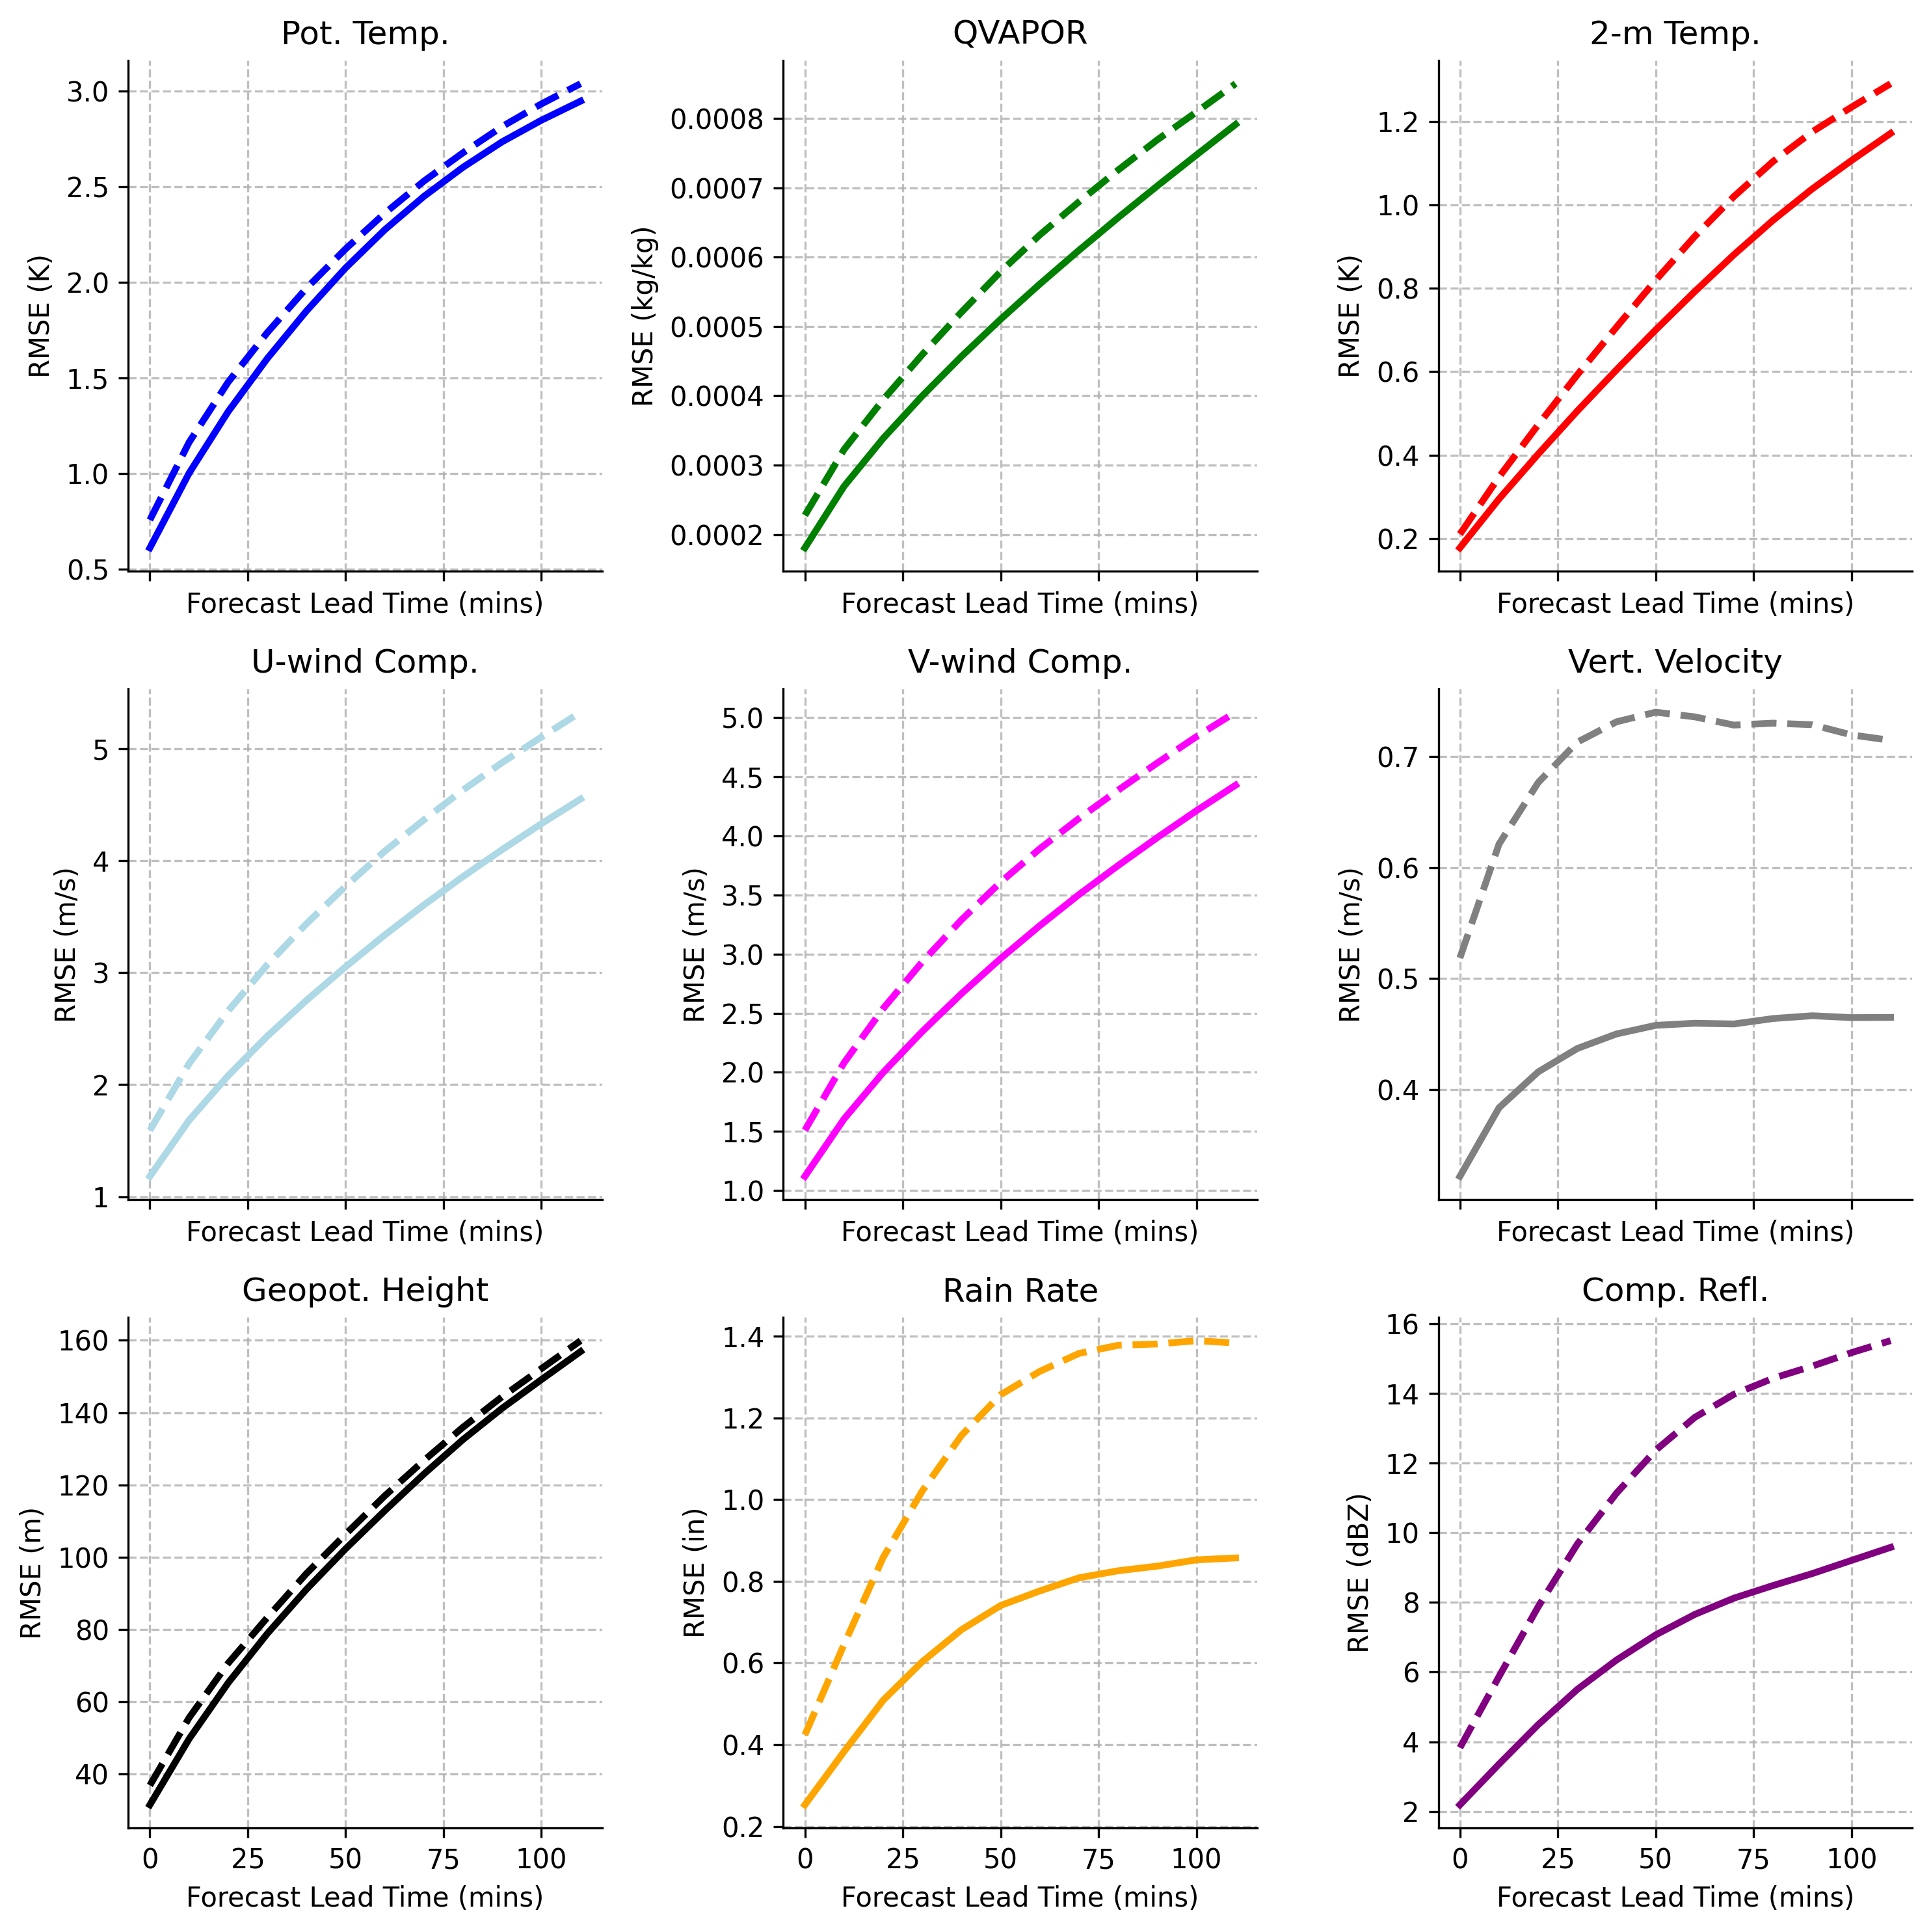

In [7]:
times = np.arange(len(predictions.time))*10 # in minutes 
fig, axes = plt.subplots(figsize=(10,10), dpi=300, ncols=3, nrows=3, sharex=True)

# Create a list of colors for each line
colors = ['blue', 'green', 'red', 'lightblue', 'magenta', 'gray', 'black', 'orange', 'purple']

for var, ax, c in zip(target_vars, axes.flat, colors): 

    ax.plot(times, rmse_dict['full'][var], c=c, lw=2.5) 
    ax.plot(times, rmse_dict['partial'][var], c=c, lw=2.5, ls='dashed')

    ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f"RMSE ({units_mapper.get(var,'')})", 
       title = display_name_mapper.get(var,var)
      )
    ax.grid(ls='dashed', alpha=0.8)
    # Hide the top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
plt.tight_layout()

## Time Series of POD, SR, CSI 

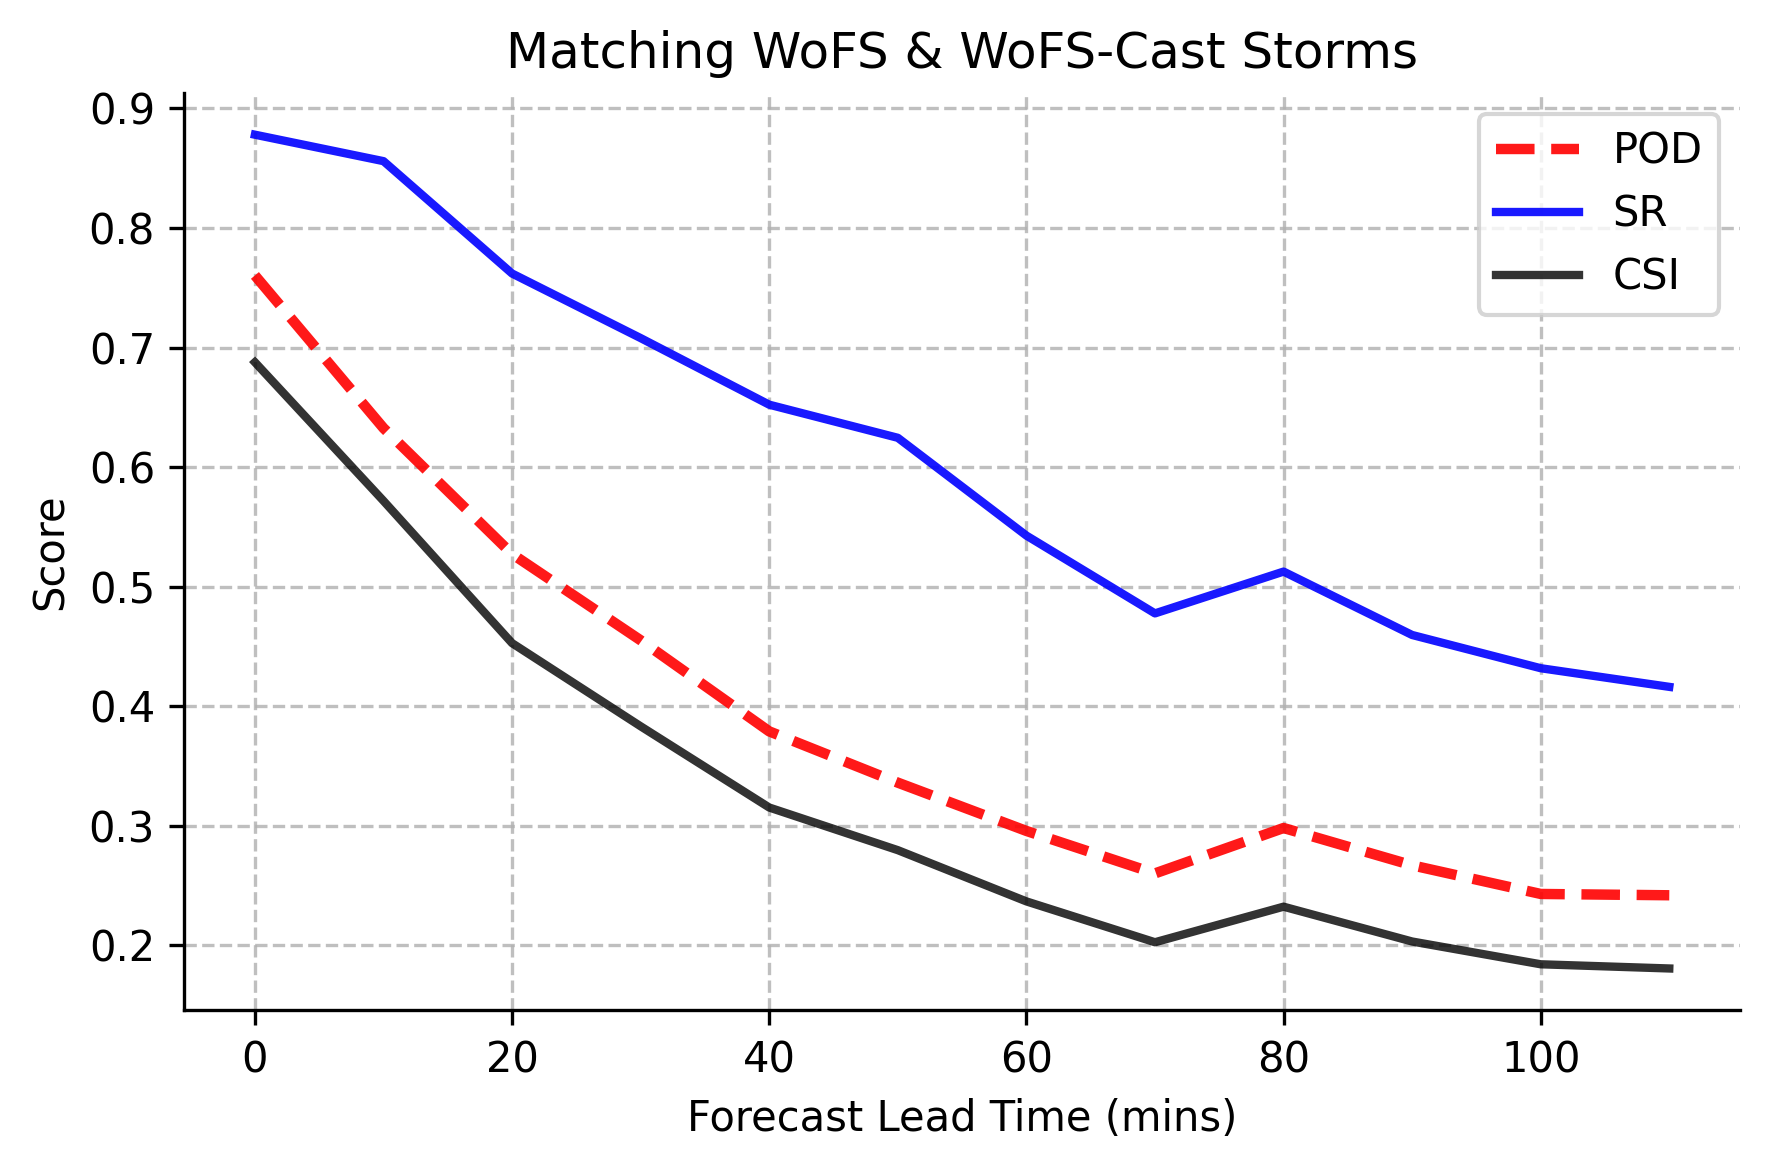

In [8]:
times = np.arange(len(predictions.time))*10 # in minutes 
fig, ax = plt.subplots(figsize=(6,4), dpi=300, )

cont_dict['hits'] = replace_zeros(cont_dict['hits'])
cont_dict['misses'] = replace_zeros(cont_dict['misses'])
cont_dict['false_alarms'] = replace_zeros(cont_dict['false_alarms'])

pod = cont_dict['hits'] / (cont_dict['hits'] + cont_dict['misses'])
sr = cont_dict['hits'] / (cont_dict['hits'] + cont_dict['false_alarms'])
csi = cont_dict['hits'] / (cont_dict['hits'] + cont_dict['misses'] + cont_dict['false_alarms'])

ax.plot(times, pod, label='POD', c='red', ls='dashed', lw=2.5, alpha=0.9)
ax.plot(times, sr, label='SR', c='blue', lw=2.0, alpha=0.9)
ax.plot(times, csi, label='CSI', c='black', lw=2.0, alpha=0.8)

ax.set(xlabel= 'Forecast Lead Time (mins)', 
       ylabel= f"Score", 
       title = 'Matching WoFS & WoFS-Cast Storms'
      )

ax.grid(ls='dashed', alpha=0.8)
# Hide the top and right spines
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
    
ax.legend()
    
plt.tight_layout()